# Zinc Human Data Cleaning and Processing for DHFR inhibitors

This is probably the most important step of all, since the data cleaning reflects directly in the **quality of your model**. For this specific notebook we will be doing the data cleaning and processing of *Human DHFR Inhibitors* (**Uniprot ID:** P00374).


### Importing the libraries:

In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat
from rdkit.Chem import rdmolops
from IPython.display import HTML
import pandas as pd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import session_info

# Code to show df properly
# Correcting the bug that shows only once the MOL structure in a jupyter notebook
# This is very important if you want to see more than once the mol depiction
def show_df(df):
    return HTML(df.to_html(notebook=True))

## Cleaning process

### Loading the dataset

In [2]:
# load the datset using pandas
human_dhfr_zinc = pd.read_csv('../datasets/raw/data/human_dhfr_zinc_structures.csv')
#The shape of the datset
print(f"\nThe shape of the dataset is {human_dhfr_zinc.shape}")
human_dhfr_zinc.head(5)


The shape of the dataset is (919, 9)


,Unnamed: 0,zinc_id,smiles,first_affinity,last_affinity,mean_affinity,chembldocid,reference.pubmed_id,reference.chembl_id
0,0,ZINC000000000640,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,10.60,7.42,8.544,13799,8632413,CHEMBL1129493
1,1,ZINC000000001233,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.25,7.25,7.250,53022,20350951,CHEMBL1255487
2,2,ZINC000000005734,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.52,9.52,9.520,13799,8632413,CHEMBL1129493
3,3,ZINC000000006585,COc1ccc(OC)c(CN(C)c2cnc3nc(N)nc(N)c3c2)c1,5.07,5.07,5.070,13858,8691474,CHEMBL1129539
4,4,ZINC000000007486,COc1ccc(C)c(NCc2cnc3nc(N)nc(N)c3c2C)c1,6.82,6.82,6.820,16403,11754578,CHEMBL1135401


In [3]:
# Selecting only the important columns
human_dhfr_zinc = human_dhfr_zinc[['chembldocid','zinc_id','smiles','first_affinity','last_affinity','mean_affinity']]

# Renaming the columns to standardize the datsets
human_dhfr_zinc.rename(columns={'chembldocid':'molecule_chembl_id', 
                                'zinc_id':'molecule_zinc_id', 
                                'first_affinity':'pKi_first_value',
                                'last_affinity':'pKi_last_value',
                                'mean_affinity': 'pKi_mean_value'
                                }, inplace=True)

# Adding the column 'target_organism' to make equal the human dhfr from chembl dataset
human_dhfr_zinc['target_organism'] = 'Homo sapiens'
human_dhfr_zinc.head(5)

,molecule_chembl_id,molecule_zinc_id,smiles,pKi_first_value,pKi_last_value,pKi_mean_value,target_organism
0,13799,ZINC000000000640,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,10.60,7.42,8.544,Homo sapiens
1,53022,ZINC000000001233,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.25,7.25,7.250,Homo sapiens
2,13799,ZINC000000005734,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.52,9.52,9.520,Homo sapiens
3,13858,ZINC000000006585,COc1ccc(OC)c(CN(C)c2cnc3nc(N)nc(N)c3c2)c1,5.07,5.07,5.070,Homo sapiens
4,16403,ZINC000000007486,COc1ccc(C)c(NCc2cnc3nc(N)nc(N)c3c2C)c1,6.82,6.82,6.820,Homo sapiens


### Removing the salts, neutralize atoms and keep only the largest fragments

In [4]:
# Defining the salts we want to remove from the database
remover = SaltRemover(defnData="[Cl,Br,Na,K,Gd]")

# Defining the function to neutralize the atoms in organic molecules
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

def keep_largest_fragment(mol):
    frags = rdmolops.GetMolFrags(mol, asMols=True)
    largest_mol = max(frags, key=lambda x: x.GetNumAtoms())
    return largest_mol

In [5]:
# Running the same function again (it's better to define a function and just call it again...)
mols = []
for i, smi in enumerate(human_dhfr_zinc.smiles):
    try:
        mol = Chem.MolFromSmiles(smi)
        mol = remover.StripMol(neutralize_atoms(mol))
        mols.append(mol)
    except:
        print(smi,i)

,molecule_chembl_id,molecule_zinc_id,smiles,pKi_first_value,pKi_last_value,pKi_mean_value,target_organism,ROMol
0,13799,ZINC000000000640,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,10.60,7.42,8.544,Homo sapiens,
1,53022,ZINC000000001233,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.25,7.25,7.250,Homo sapiens,
2,13799,ZINC000000005734,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.52,9.52,9.520,Homo sapiens,
3,13858,ZINC000000006585,COc1ccc(OC)c(CN(C)c2cnc3nc(N)nc(N)c3c2)c1,5.07,5.07,5.070,Homo sapiens,
4,16403,ZINC000000007486,COc1ccc(C)c(NCc2cnc3nc(N)nc(N)c3c2C)c1,6.82,6.82,6.820,Homo sapiens,

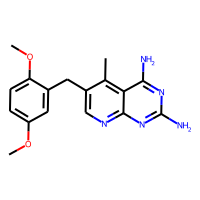
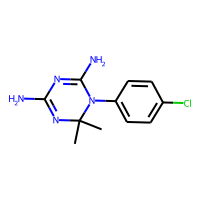
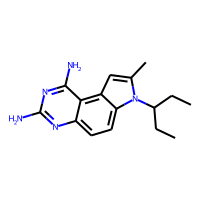
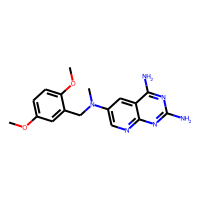
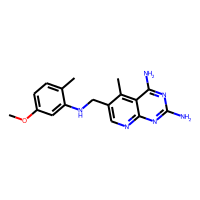

In [6]:
PandasTools.AddMoleculeColumnToFrame(human_dhfr_zinc, smilesCol='smiles')
human_dhfr_zinc.head(5)

,molecule_chembl_id,molecule_zinc_id,smiles,pKi_first_value,pKi_last_value,pKi_mean_value,target_organism,ROMol,Mol_Clean
0,13799,ZINC000000000640,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,10.60,7.42,8.544,Homo sapiens,,
1,53022,ZINC000000001233,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.25,7.25,7.250,Homo sapiens,,
2,13799,ZINC000000005734,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.52,9.52,9.520,Homo sapiens,,
3,13858,ZINC000000006585,COc1ccc(OC)c(CN(C)c2cnc3nc(N)nc(N)c3c2)c1,5.07,5.07,5.070,Homo sapiens,,
4,16403,ZINC000000007486,COc1ccc(C)c(NCc2cnc3nc(N)nc(N)c3c2C)c1,6.82,6.82,6.820,Homo sapiens,,

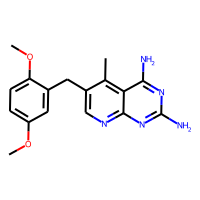
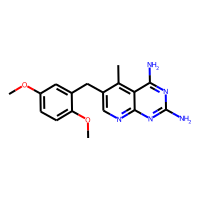
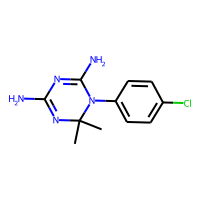
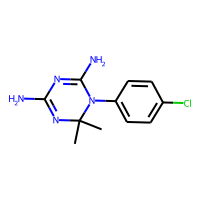
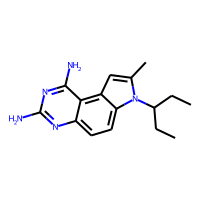
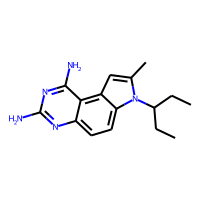
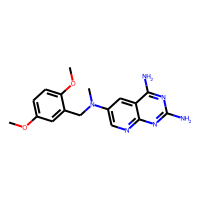
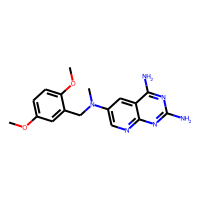
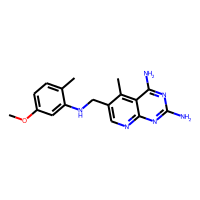
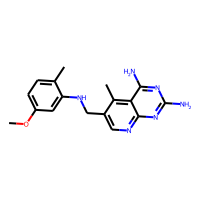

In [7]:
# Keep largest fragment
human_dhfr_zinc["Mol_Clean"] = human_dhfr_zinc.ROMol.apply(keep_largest_fragment)

# Strip mol
human_dhfr_zinc["Mol_Clean"] = human_dhfr_zinc.Mol_Clean.apply(remover.StripMol)

# Neutralize atoms
human_dhfr_zinc["Mol_Clean"] = human_dhfr_zinc.Mol_Clean.apply(neutralize_atoms)

show_df(human_dhfr_zinc.head(5))

Creating a column of smiles from the `Mol_Clean` structures and then, 
lastly, we can save the dataset into a '.csv' file with the following variables:
* molecule_chembl_id
* molecule_zinc_id
* smiles_clean
* pKi_mean_value
* pKi_last_value
* pKi_first_value
* target_organism

,molecule_zinc_id,molecule_chembl_id,smiles_clean,pKi_mean_value,pKi_last_value,pKi_first_value,target_organism,ROMol
0,ZINC000000000640,13799,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,8.544,7.42,10.60,Homo sapiens,
1,ZINC000000001233,53022,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.250,7.25,7.25,Homo sapiens,
2,ZINC000000005734,13799,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.520,9.52,9.52,Homo sapiens,
3,ZINC000000006585,13858,COc1ccc(OC)c(CN(C)c2cnc3nc(N)nc(N)c3c2)c1,5.070,5.07,5.07,Homo sapiens,
4,ZINC000000007486,16403,COc1ccc(C)c(NCc2cnc3nc(N)nc(N)c3c2C)c1,6.820,6.82,6.82,Homo sapiens,

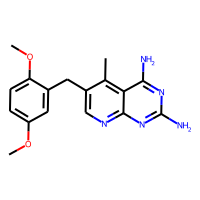
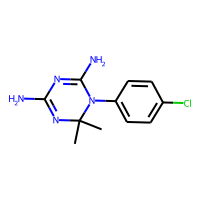
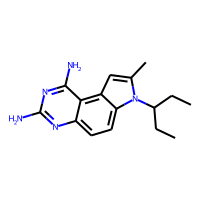
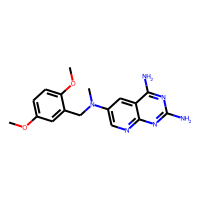
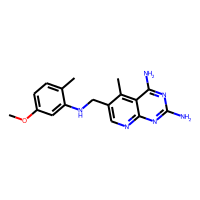

In [8]:
# transforming the mol_clean variable into smiles:
human_dhfr_zinc['smiles_clean'] = human_dhfr_zinc.Mol_Clean.apply(Chem.MolToSmiles)

# Saving only the important variables
human_dhfr_zinc = human_dhfr_zinc[['molecule_zinc_id','molecule_chembl_id', 'smiles_clean', 'pKi_mean_value', 'pKi_last_value', 'pKi_first_value', 'target_organism']]

# Checking one final time if the smiles_clean can be interconverted to mol again
PandasTools.AddMoleculeColumnToFrame(human_dhfr_zinc, smilesCol='smiles_clean')
show_df(human_dhfr_zinc.head(5))

## Saving the output

In [9]:
# Dropping the column
human_dhfr_zinc.drop('ROMol', axis=1, inplace=True)

# Making a function to standardize the chembl ID column
def chembl_id_func(chembl_id):
    chembl_id = str(chembl_id)
    return 'CHEMBL'+chembl_id

human_dhfr_zinc['molecule_chembl_id'] = human_dhfr_zinc.molecule_chembl_id.apply(chembl_id_func)
show_df(human_dhfr_zinc.head(3))

,molecule_zinc_id,molecule_chembl_id,smiles_clean,pKi_mean_value,pKi_last_value,pKi_first_value,target_organism
0,ZINC000000000640,CHEMBL13799,COc1ccc(OC)c(Cc2cnc3nc(N)nc(N)c3c2C)c1,8.544,7.42,10.60,Homo sapiens
1,ZINC000000001233,CHEMBL53022,CC1(C)N=C(N)N=C(N)N1c1ccc(Cl)cc1,7.250,7.25,7.25,Homo sapiens
2,ZINC000000005734,CHEMBL13799,CCC(CC)n1c(C)cc2c3c(N)nc(N)nc3ccc21,9.520,9.52,9.52,Homo sapiens


In [10]:
# Saving the final dataset to a clean csv:
human_dhfr_zinc.to_csv('cleaned_data/clean_human_dhfr_zinc.csv', index=False)